# AlexNet

## Imports

In [1]:
# Import Library
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import os
import tensorflow as tf
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

2024-06-18 15:12:49.781277: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 15:12:49.781370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 15:12:49.921003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Paths

In [2]:
#defining training and testing path for vgg16
train_path = '/kaggle/input/intel-image/archive/seg_train/seg_train'
test_path = '/kaggle/input/intel-image/archive/seg_test/seg_test'


## Load Data

In [3]:
image_size = (150, 150) # 150x150 pixels

def load_images(path):
    X = []
    y = []

    folders = sorted(os.listdir(path), key=lambda x: os.path.getmtime(os.path.join(path, x)))

    for i, folder in enumerate(folders):
        for file in os.listdir(os.path.join(path, folder)):
            img = cv2.imread(os.path.join(path, folder, file))
            img = cv2.resize(img, image_size)
            X.append(img)
            y.append(i)

    return np.array(X), np.array(y)

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)


## Number of Classes

In [4]:
# The number of classes of dataset
numberOfClass = len(glob(train_path + "/*"))
print("Number Of Class: ", numberOfClass)

Number Of Class:  6


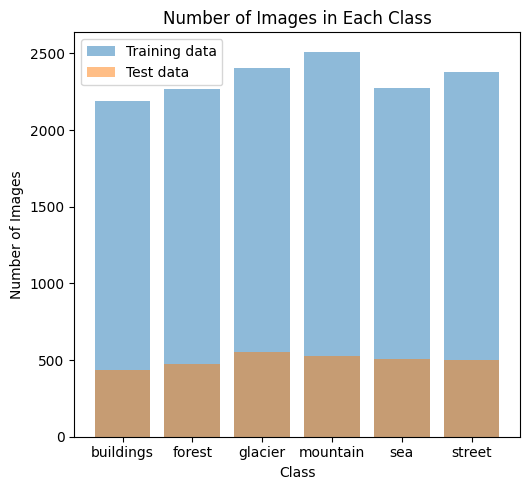

In [5]:
# plot the number if images in each class in the training and test data
labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(*np.unique(y_train, return_counts=True), label='Training data', alpha=0.5)
plt.bar(*np.unique(y_test, return_counts=True), label='Test data', alpha=0.5)
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(range(len(labels)), labels.values())  # Set the x-axis tick labels
plt.legend()
plt.tight_layout()
plt.show()


## Show Data

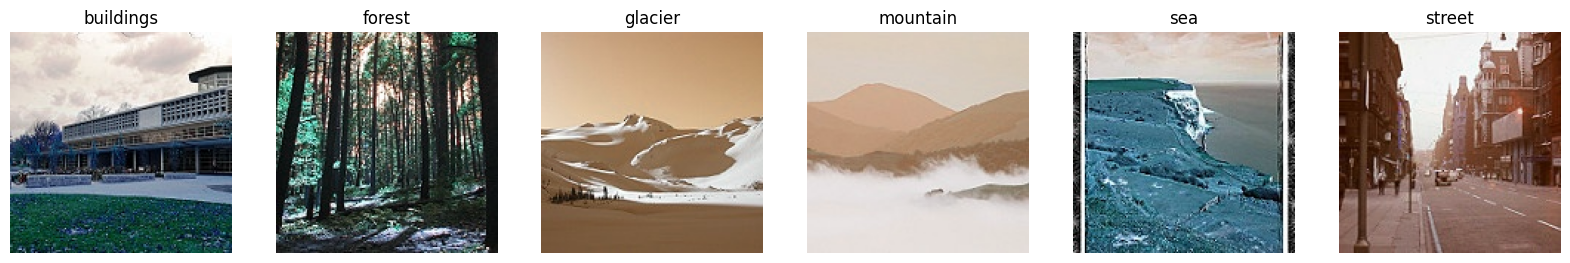

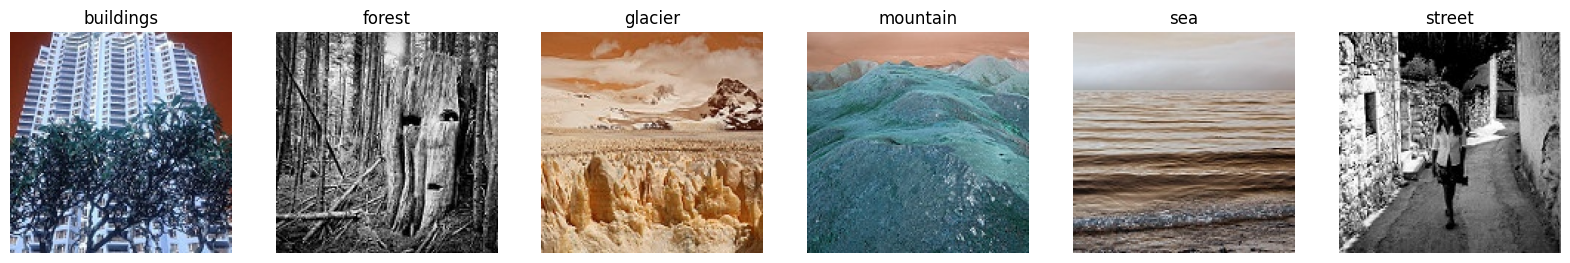

In [6]:
# display some images from the training data per class
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axes[i].imshow(X_train[y_train == i][0])
    axes[i].set_title(labels[i])
    axes[i].axis('off')
plt.show()

# display some images from the test data per class
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axes[i].imshow(X_test[y_test == i][0])
    axes[i].set_title(labels[i])
    axes[i].axis('off')
plt.show()

## Split Training and Validation Data

In [7]:
# one-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# split the training data into training and validation data
# 80% of the data will be used for training and 20% for validation
# split the data stratified by the labels
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [8]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

(11227, 150, 150, 3)
(11227, 6)
(2807, 150, 150, 3)
(2807, 6)


## Normalize Data

In [9]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

## Model Architecture

In [10]:
model = Sequential()

model.add(Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(150, 150, 3), name="conv0"))
model.add(BatchNormalization(axis=3, name="bn0"))
model.add(MaxPooling2D((3, 3), strides=2, name="max0"))

model.add(Conv2D(256, (5, 5), activation='relu', padding='same', name="conv1"))
model.add(BatchNormalization(axis=3, name="bn1"))
model.add(MaxPooling2D((3, 3), strides=2, name="max1"))

model.add(Conv2D(384, (3, 3), activation='relu', padding='same', name="conv2"))
model.add(BatchNormalization(axis=3, name="bn2"))

model.add(Conv2D(384, (3, 3), activation='relu', padding='same', name="conv3"))
model.add(BatchNormalization(axis=3, name="bn3"))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name="conv4"))
model.add(BatchNormalization(axis=3, name="bn4"))
model.add(MaxPooling2D((3, 3), strides=2, name="max2"))

model.add(Flatten())

model.add(Dense(4096, activation='relu', name="fc0"))

model.add(Dense(4096, activation='relu', name="fc1"))

model.add(Dense(6, activation='softmax', name="fc2"))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv0 (Conv2D)                  │ (None, 35, 35, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 35, 35, 96)     │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max0 (MaxPooling2D)             │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 17, 17, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 17, 17, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max1 (MaxPooling2D)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 8, 8, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 8, 8, 384)      │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 8, 8, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 8, 8, 384)      │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 8, 8, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 8, 8, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2 (MaxPooling2D)             │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc0 (Dense)                     │ (None, 4096)           │     9,441,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 6)              │        24,582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,999,878 (114.44 MB)

 Trainable params: 29,997,126 (114.43 MB)

 Non-trainable params: 2,752 (10.75 KB)

## Train Model

In [11]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
  5/351 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.2565 - loss: 21.3295 

I0000 00:00:1718723675.130456     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718723675.152788     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5060 - loss: 3.0697

W0000 00:00:1718723692.506473     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


351/351 ━━━━━━━━━━━━━━━━━━━━ 32s 57ms/step - accuracy: 0.5062 - loss: 3.0652 - val_accuracy: 0.3078 - val_loss: 2.3669
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.6536 - loss: 0.9200 - val_accuracy: 0.3573 - val_loss: 2.1865
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.6981 - loss: 0.8265 - val_accuracy: 0.4945 - val_loss: 1.3586
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7406 - loss: 0.7155 - val_accuracy: 0.6313 - val_loss: 1.0167
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7580 - loss: 0.6636 - val_accuracy: 0.5080 - val_loss: 1.4640
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7884 - loss: 0.5974 - val_accuracy: 0.4581 - val_loss: 1.6422
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7904 - loss: 0.5938 - val_accuracy: 0.6356 - val_loss: 1.1635
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8247 - loss: 0.4882 - val_accuracy: 0.64

# Save the Model

In [12]:
model.save("alexnet.h5")
model.save_weights("alexnet.weights.h5")

## Performance metrics 

### Accuracy and Loss

In [13]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15, 10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "Train Accuracy")
    plt.plot(history.history['val_accuracy'], label = "Validation Accuracy")
    plt.title("Train Accuracy vs Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label = "Train Loss")
    plt.plot(history.history['val_loss'], label = "Validation Loss")
    plt.title("Train Loss vs Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()

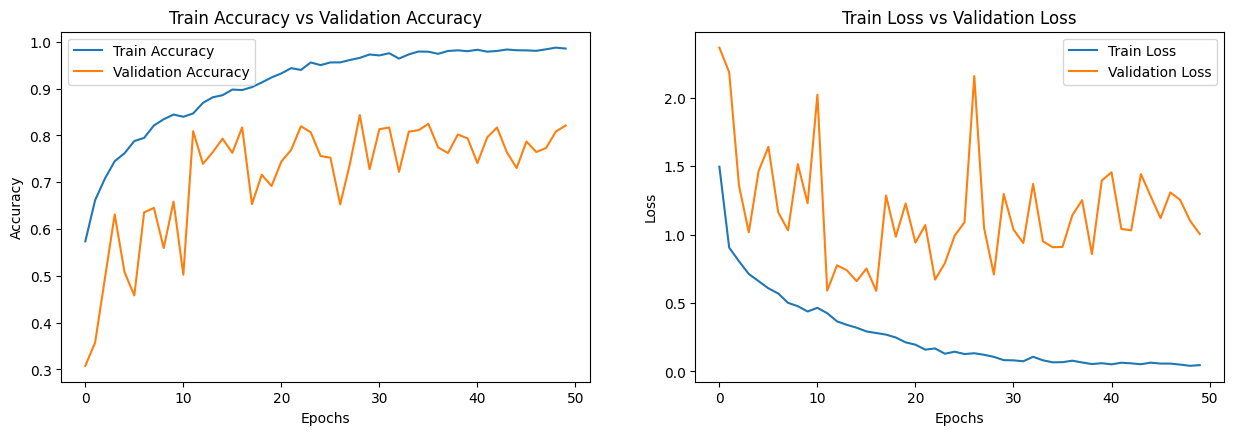

In [14]:
plot_accuracy_loss(history)

### Classification Report and Confusion Matrix 

22/94 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

W0000 00:00:1718724141.273040     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       437
           1       0.90      0.96      0.93       474
           2       0.75      0.75      0.75       553
           3       0.77      0.72      0.74       525
           4       0.84      0.85      0.84       510
           5       0.89      0.82      0.85       501

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000



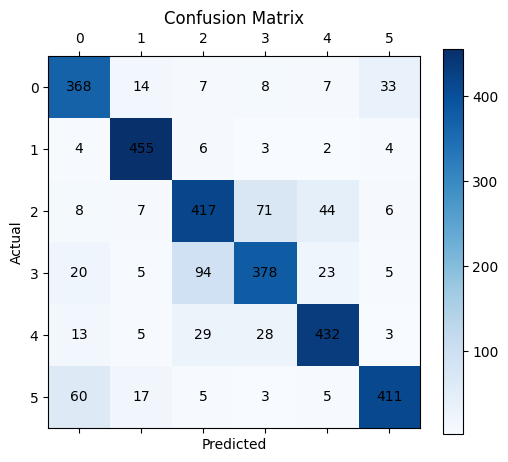

In [15]:
# Confusion Matrix
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)  
confusion = confusion_matrix(true_labels, y_pred)

fig, ax = plt.subplots(figsize=(6, 5)) 
cax = ax.matshow(confusion, cmap='Blues')
fig.colorbar(cax)

print(classification_report(true_labels, y_pred))

for (i, j), val in np.ndenumerate(confusion):
    ax.text(j, i, f'{val}', ha='center', va='center')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Accuracy of Training, Validation and Testing data

In [16]:
print("Accuracy of the model using training data is - ", model.evaluate(X_train,y_train)[1]*100,"%")
print("Accuracy of the model using validation data is - ", model.evaluate(X_val,y_val)[1]*100,"%")
print("\nAccuracy of the model is - ", model.evaluate(X_test,y_test)[1]*100,"%")

351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9787 - loss: 0.0597
Accuracy of the model using training data is -  97.76431918144226 %
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8161 - loss: 1.0299
Accuracy of the model using validation data is -  82.11613893508911 %
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8427 - loss: 0.8599

Accuracy of the model is -  82.03333616256714 %


### ROC Curve

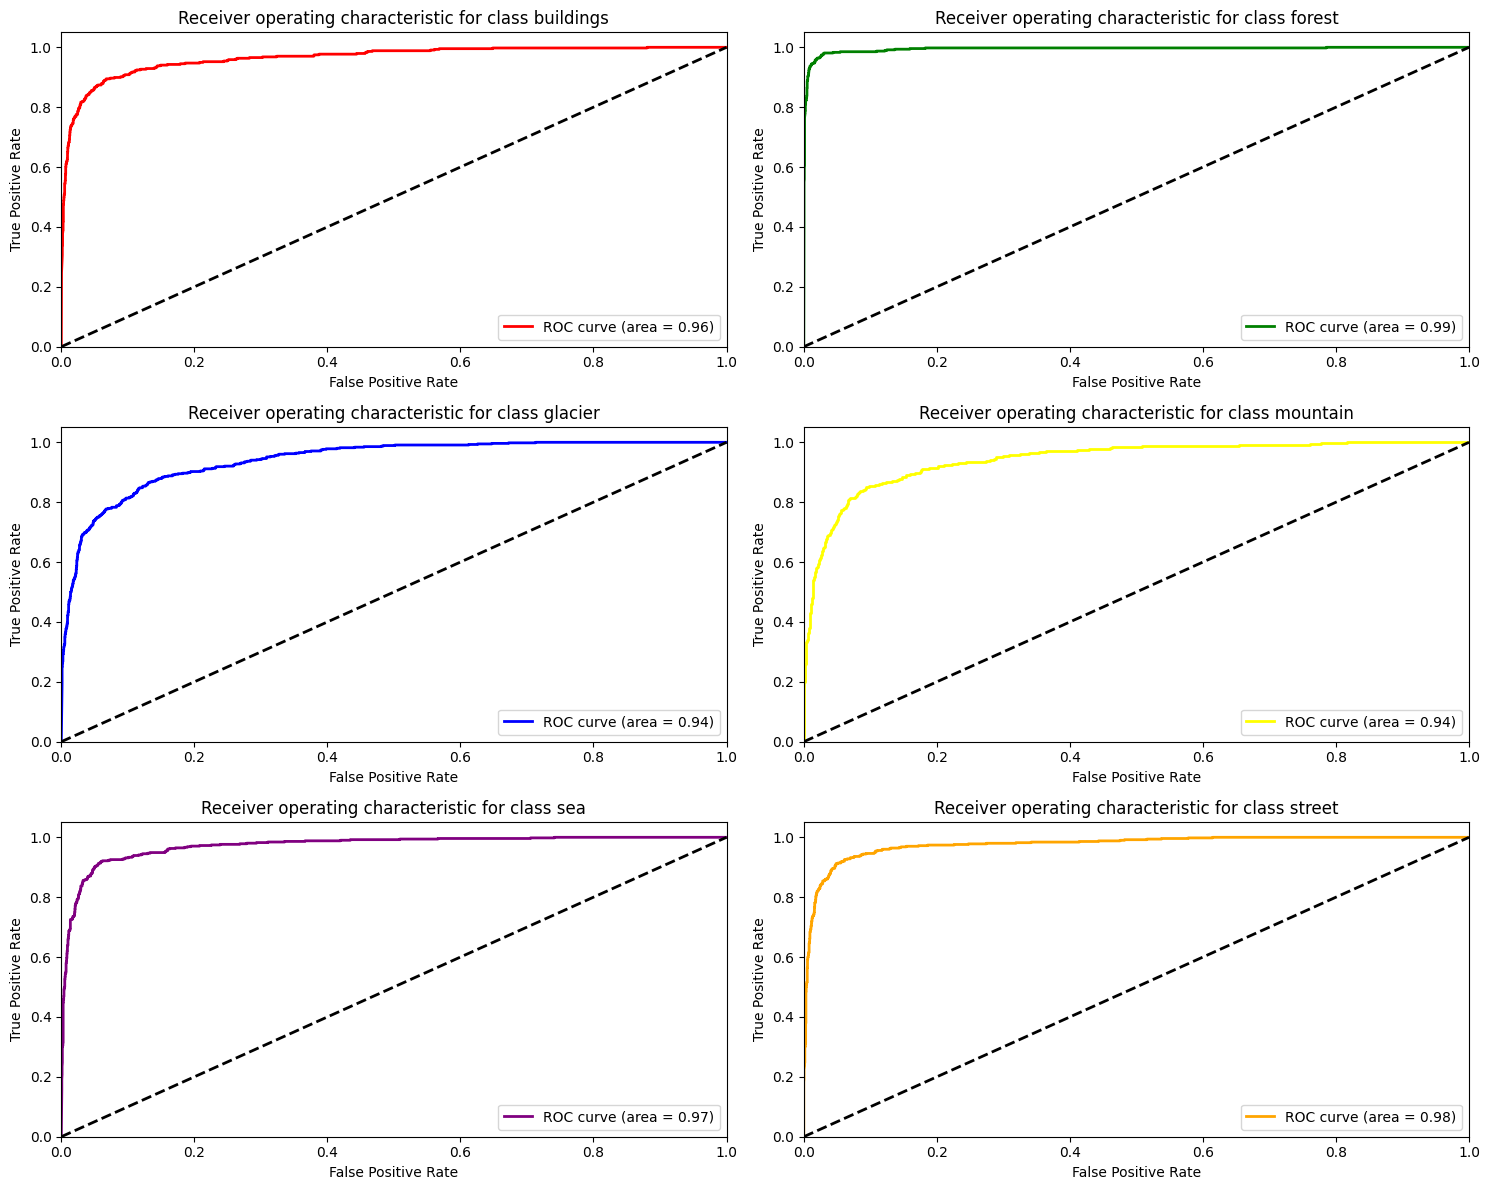

In [17]:
labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
unique_classes = [0, 1, 2, 3, 4, 5]

y_train_bin = label_binarize(y_train, classes=unique_classes)
y_test_bin = label_binarize(y_test, classes=unique_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

num_classes = len(unique_classes)

# Criação de figuras e subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 12))  # 3 linhas, 2 colunas

# Cores para as classes
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

# Iteração sobre todas as classes
for i, ax in enumerate(axs.flat):
    # Seleciona a classe atual
    class_index = i % num_classes
    
    # Calcula FPR, TPR e AUC para a classe atual
    fpr[class_index], tpr[class_index], _ = roc_curve(y_test_bin[:, class_index], predictions[:, class_index])
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])
    
    # Plota a curva ROC
    ax.plot(fpr[class_index], tpr[class_index], color=colors[class_index % len(colors)], lw=2,
            label=f'ROC curve (area = {roc_auc[class_index]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic for class {}'.format(labels.get(class_index)))
    ax.legend(loc="lower right")

plt.tight_layout()  
plt.show()